In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
sys.path.append("../utils/")
sys.path.append("../")

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import metrics
from agg_crossfit_results import *

In [4]:
pd.set_option('display.max_rows', 500)


In [5]:
set_name = 'third_set'
metrics_type = 'auc'
base_dir="../runs/pretrained/1e-4/0/"
model_mapping = {
    'BART-Single': 1,
    'BART-Adapter-Single': 2,
    'BART-BiHNet-Single': 3,
    'BART-Adapter-Vanilla':4, 
    'BART-BiHNet+Vanilla':5,
    'BART-BiHNet+Reg':6,
    'BART-BiHNet+EWC':7,
    'BART-Adapter-Multitask':8,
    'BART-BiHNet-Multitask':9}

# Few shot

In [6]:
dir_dict = {"BART-BiHNet+Reg":f"../runs/BiHNet_Reg_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet+EWC":f"../runs/BiHNet_ewc_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-Adapter-Multitask": f"../runs/adpter_mtl_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet-Multitask": f"../runs/mtl_hnet_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-Adapter-Vanilla": f"../runs/adapter_vanilla_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet+Vanilla": f"../runs/BiHNet_vanilla_{set_name}_0.01_s64_d256_limit/1e-4/0/",
#             "BART-Single": f"../runs/single_{set_name}_fs_0.01_s64_d256_limit/1e-4/0/",
#             "BART-Adapter-Single": f"../runs/adapter_single_{set_name}_fs_0.01_s64_d256_limit/1e-4/0/",
#             "BART-BiHNet-Single": f"../runs/BiHNet_single_{set_name}_fs_0.01_s64_d256_limit/1e-4/0/",
           }

In [7]:
def get_fs_df(dir_dict, metrics_type, k=16):
    postfix = f"_naive_{k}shot"
    dfs = []
    for alg in dir_dict:
        print(alg)
        for with_dash in [True, False]:
            df =  make_few_shot_result_table(dir_dict[alg], postfix=postfix, metrics_type=metrics_type, with_dash=with_dash)
            if df.empty:
                print("df", df)
                print(alg, with_dash, "hereeee")
                continue
            if "task_detail" in df.columns:
                df = pd.DataFrame(df.groupby(["task_name", "task_detail"])[metrics_type].max()).reset_index()
            else:
                df = pd.DataFrame(df.groupby(["task_name"])[metrics_type].max()).reset_index()
            df["alg"] = alg
            df['k'] = k
            dfs.append(df)
    all_fs_df = pd.concat(dfs)
    all_fs_df = all_fs_df[[metrics_type, "task_name", "task_detail",  "alg", "k"]]
    all_fs_df = all_fs_df.rename(columns={metrics_type: f'few-shot-{metrics_type}', 
                                                      'alg': 'model', 
                                                      'task_name': 'dataset', 
                                                      'task_detail': 'task'})
    return all_fs_df

In [8]:
all_fs_df = []
for k in ["8", "16", "32"]:
    fs_auc_df = get_fs_df(dir_dict, metrics_type='auc', k=k)
    fs_f1_df = get_fs_df(dir_dict, metrics_type='f1', k=k)
    fs_df = fs_f1_df.merge(fs_auc_df, on=['model', 'dataset', 'task', "k"])
    all_fs_df.append(fs_df)
all_fs_df = pd.concat(all_fs_df)

BART-BiHNet+Reg
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-BiHNet+EWC
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-Adapter-Multitask
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-BiHNet-Multitask
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-Adapter-Vanilla
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-BiHNet+Vanilla
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-BiHNet+Reg
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-BiHNet+EWC
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-Adapter-Multitask
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-BiHNet-Multitask
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_8shot.csv
BART-Adapter-Va

In [9]:
fs_agg = all_fs_df.groupby(["model", "k"], as_index=False).aggregate({'few-shot-auc':'mean','few-shot-f1':"mean"})

In [10]:
fs_agg['k'] = fs_agg['k'].astype(int)

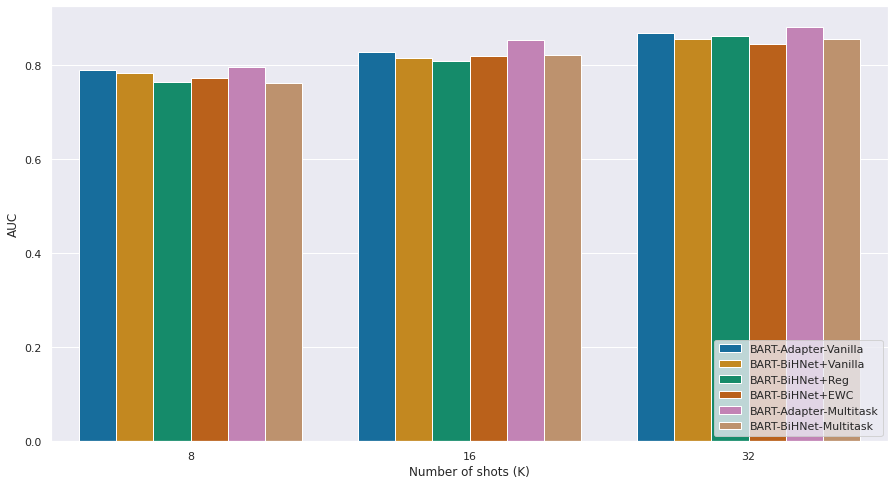

In [12]:
sns.set(rc={'figure.figsize':(15,8)})
hue_order = ['BART-Adapter-Vanilla', 'BART-BiHNet+Vanilla', 'BART-BiHNet+Reg', 'BART-BiHNet+EWC',
             'BART-Adapter-Multitask', 'BART-BiHNet-Multitask']
g = sns.barplot(x="k", y="few-shot-auc", hue="model", data=fs_agg, 
            hue_order=hue_order, palette='colorblind')

plt.legend(loc='lower right')
plt.ylabel("AUC")
plt.xlabel("Number of shots (K)")
plt.savefig("auc_kshot.jpg")